This example quantifies the effect of back-reaction.

# Import Modules

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

#Current Working Directory
import os
cwd = os.getcwd()

from pathlib import Path

In [22]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]


from astropy.io import fits

import numpy as np
import copy
import pickle

import darkhistory.physics as phys
import darkhistory.utilities as utils
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
import darkhistory.spec.transferfunclist as tflist
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
import darkhistory.history.tla as tla

from scipy.interpolate import interp1d
from scipy.interpolate import interp2d

from tqdm import tqdm_notebook as tqdm

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec
from darkhistory.electrons.ics.ics_cooling import get_ics_cooling_tf

from darkhistory.low_energy.lowE_deposition import compute_fs
import main

from tqdm import tqdm_notebook as tqdm

np.set_printoptions(threshold=np.nan)

In [3]:
soln = pickle.load(open("../darkhistory/history/std_soln.p", "rb"))
xe_std  = interp1d(soln[0,:], soln[2,:])
T_m_std = interp1d(soln[0,:], soln[1,:])

## Load Transfer Functions

In [4]:
%autoreload

CMB_subtracted=True
direc = '/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition'
highengphot_tf_interp = pickle.load(open(direc+"/tfs_20190120/processed/highengphot_tf_interp.raw", "rb"))
lowengphot_tf_interp  = pickle.load(open(direc+"/tfs_20190120/processed/lowengphot_tf_interp.raw", "rb"))
lowengelec_tf_interp  = pickle.load(open(direc+"/tfs_20190120/processed/lowengelec_tf_interp.raw", "rb"))
highengdep_interp     = pickle.load(open(direc+"/tfs_20190120/processed/highengdep_interp.raw", "rb"))
CMB_engloss_interp    = pickle.load(open(direc+"/tfs_20190120/processed/CMB_engloss_interp.raw", "rb"))
    
# Useful Definitions
photeng = highengphot_tf_interp.eng
eleceng = lowengelec_tf_interp.eng

### ics transfer functions

In [5]:
%autoreload
direc = cwd+'/../../tfs/ics/'
ics_file = Path(direc+'ics_thomson_ref_tf.p')

if ics_file.is_file():
    ics_thomson_ref_tf = pickle.load(open(direc+'ics_thomson_ref_tf.p', "rb"))
    ics_rel_ref_tf = pickle.load(open(direc+'ics_rel_ref_tf.p', "rb"))
    engloss_ref_tf = pickle.load(open(direc+'engloss_ref_tf.p', "rb"))
else:
    ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf = main.load_ics_data()
    pickle.dump(ics_thomson_ref_tf, open(direc+'ics_thomson_ref_tf.p', "wb"))
    pickle.dump(ics_rel_ref_tf, open(direc+'ics_rel_ref_tf.p', "wb"))
    pickle.dump(engloss_ref_tf, open(direc+'engloss_ref_tf.p', "wb"))

In [6]:
struct_data = np.loadtxt(open(cwd+"/../structure_formation_data/boost_Einasto_subs.txt", "rb"))

log_struct_interp = interp1d(np.log(struct_data[:,0]), np.log(struct_data[:,1]))

def struct_boost_einasto(rs):
    if rs < 76:
        return np.exp(log_struct_interp(np.log(rs)))
    else:
        return 1
struct_boost = struct_boost_einasto

## $\chi \chi \to \bar{b} b$

In [7]:
mDM=49e9
sigmav = 1.75e-26
inj_type='swave'

In [9]:
import csv
with open(direc+'/elec_spec.csv', 'r') as f:
    reader = csv.reader(f)
    elecDat = list(reader)
elecDat = np.array([[float(str.split(dat[0],'\t')[0]), float(str.split(dat[0],'\t')[1])] 
           for dat in elecDat])

with open(direc+'/phot_spec.csv', 'r') as f:
    reader = csv.reader(f)
    photDat = list(reader)
photDat = np.array([[float(str.split(dat[0],'\t')[0]), float(str.split(dat[0],'\t')[1])] 
           for dat in photDat])

elecInterp = interp1d(elecDat[:,0], elecDat[:,1])
photInterp = interp1d(photDat[:,0], photDat[:,1])

In [11]:
# elecBnds = spectools.get_bin_bound(eleceng)
# photBnds = spectools.get_bin_bound(photeng)
#WARNING!!!: I think discretize was mislabeled because I think it asked me 
#            to input bin bounds when I think it wanted bin centers 

elec_spec_init = spectools.discretize(eleceng,elecInterp)
phot_spec_init = spectools.discretize(photeng,photInterp)

elec_spec_init *= .19*mDM/elec_spec_init.toteng()
phot_spec_init *= .28*mDM/phot_spec_init.toteng()

elec_spec_init.rs = 3000
elec_spec_init.switch_spec_type()

phot_spec_init.rs = 3000
phot_spec_init.switch_spec_type()

In [13]:
%autoreload

coarsen_factor=16
Ecom=mDM
end_rs=4.995

def rate_func_N(rs):
    return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav = sigmav)*struct_boost(rs)/Ecom
def rate_func_eng(rs):
    return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav = sigmav)*struct_boost(rs)


withDM_noBR = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    highengdep_interp, CMB_engloss_interp,
    ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
    coarsen_factor=coarsen_factor, std_soln=True,
    reion_switch=False,
    struct_boost=struct_boost,
    ics_only=False, separate_higheng=True, CMB_subtracted=CMB_subtracted,
    user=None, verbose=False, 
    use_tqdm=True
)

../darkhistory/spec/spectra.py:401: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  np.issubdtype(type(other), float)
../darkhistory/spec/spectra.py:402: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  or np.issubdtype(type(other), int)


In [24]:
noDM = main.evolve(
    elec_spec_init*0, phot_spec_init*0,
    rate_func_N, rate_func_eng, end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    highengdep_interp, CMB_engloss_interp,
    ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
    coarsen_factor=coarsen_factor, std_soln=True,
    reion_switch=False,
    struct_boost=struct_boost,
    ics_only=False, separate_higheng=True, CMB_subtracted=CMB_subtracted,
    user=None, verbose=False, 
    use_tqdm=True
)

In [28]:
withDM_BR = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    highengdep_interp, CMB_engloss_interp,
    ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
    coarsen_factor=coarsen_factor, std_soln=False,
    reion_switch=False,
    struct_boost=None,
    ics_only=False, separate_higheng=True, CMB_subtracted=CMB_subtracted,
    use_tqdm=True
)

../darkhistory/spec/spectra.py:401: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  np.issubdtype(type(other), float)
../darkhistory/spec/spectra.py:402: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  or np.issubdtype(type(other), int)


In [29]:
withDM_noBR = a

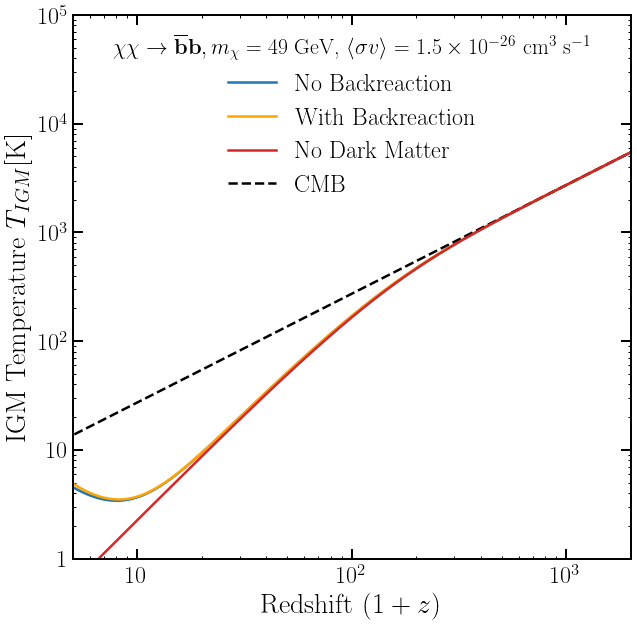

In [30]:
plt.figure()
ax = plt.gca()
ax.loglog()

plt.xlabel('Redshift $(1+z)$')
plt.ylabel('IGM Temperature $T_{IGM}$[K]')

rs_list = withDM_noBR[3].rs[:-1]

plt.axis([5, 2e3, 1, 1e5])
# plt.axvline(5.8, color='gray', linestyle='--', alpha=0.3)

plot_noBR, = plt.plot(rs_list, withDM_noBR[1][:]/phys.kB, label='No Backreaction', color='C0')
plot_BR, = plt.plot(rs_list, withDM_BR[1][:]/phys.kB, label='With Backreaction', color='orange')
plot_CMB, = plt.plot(rs_list, phys.TCMB(rs_list)/phys.kB, label='CMB', color='k', linestyle='--')
plot_std, = plt.plot(rs_list, noDM[1][:]/phys.kB, label='No Dark Matter', color='C3')

legend = plt.legend(handles=[plot_noBR, plot_BR, plot_std, plot_CMB], loc=9,
           frameon=False, title='$\mathbf{\chi\chi \\rightarrow \overline{b}b}, m_\chi = 49$ GeV,'+
                    ' $\langle \sigma v \\rangle = 1.5 \\times 10^{-26}$ cm$^3$ s$^{-1}$')
legend.get_title().set_fontsize('22')

# plt.savefig('/Users/'+user+'/Dropbox (MIT)/Photon Deposition/Draft/plots/bb_bar_swave_T.png')

-The above is an example of what inputs need to be put in the code (back-reaction, structure formation, input spectra)

-Fix the normalization

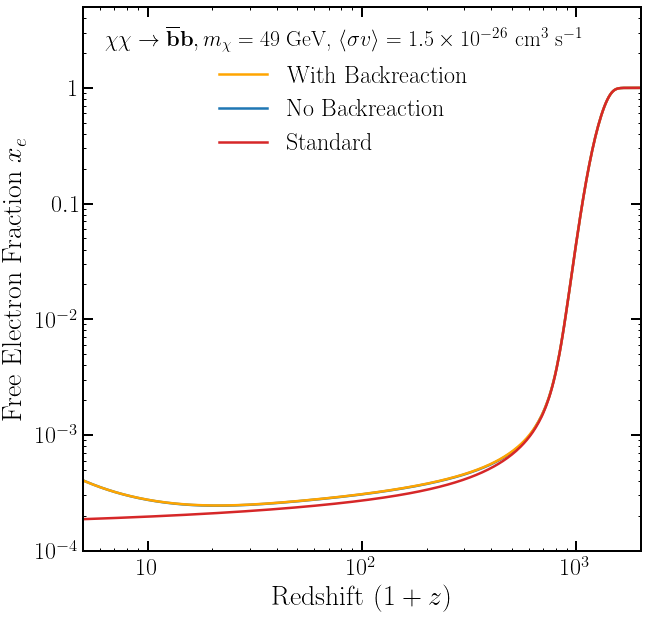

In [33]:
plt.figure()
ax = plt.gca()
ax.loglog()

plt.xlabel('Redshift $(1+z)$')
plt.ylabel('Free Electron Fraction $x_e$')

plt.axis([5, 2e3, 1e-4, 5])
# plt.axvline(7, color='gray', linestyle='--', alpha=0.3)

plot_noBR, = plt.plot(rs_list, withDM_noBR[0][:,0], label='No Backreaction', color='C0')
plot_BR, = plt.plot(rs_list, withDM_BR[0][:,0], label='With Backreaction', color='orange')
plot_std, = plt.plot(rs_list, noDM[0][:,0], label='Standard', color='C3')

legend = plt.legend(handles=[plot_BR, plot_noBR, plot_std], loc=0, 
           frameon=False, title='$\mathbf{\chi\chi \\rightarrow \overline{b}b}, m_\chi = 49$ GeV,'+
                    ' $\langle \sigma v \\rangle = 1.5 \\times 10^{-26}$ cm$^3$ s$^{-1}$')
legend.get_title().set_fontsize('22')

# plt.savefig('/Users/'+user+'/Dropbox (MIT)/Photon Deposition/Draft/plots/bb_bar_swave_xe.png')